# R-R intervals time series
## Facultad de Ciencias, UNAM
### Ana Daniela del Río Pulido and Erin C. McKiernan

Functions used in previous notebooks will be used. To exemplify, we will use the meditation recordings as well as one recording in rest and after performing exercise.

The objective of this notebook is to visualize the techniques used in previous notebooks (phase space recontruction and recurrence plot), but only using the R/R intervals time series. Consider that there must be an adequate R peak detection in the recording.

# Setting up the notebook

We begin by setting up the Jupyter notebook and importing the Python modules needed for plotting figures, create animations, etc. We include commands to view plots in the Jupyter notebook, and to create figures with good resolution and large labels. These commands can be customized to produce figures with other specifications.

In [1]:
# Imports python libraries
import numpy as np
import random as rd
import wave
import sys
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
sys.path.insert(1, r'./../functions') # add to pythonpath

# commands to create high-resolution figures with large labels
%config InlineBackend.figure_formats = {'png', 'retina'} 
plt.rcParams['figure.dpi'] = 50
plt.rcParams['axes.labelsize'] = 16 # fontsize for figure labels
plt.rcParams['axes.titlesize'] = 18 # fontsize for figure titles
plt.rcParams['font.size'] = 14 # fontsize for figure numbers
plt.rcParams['lines.linewidth'] = 1.4 # line width for plotting

## Extracting data

ECG recordings were obtained using the Backyard Brains Heart and Brain Spiker Box. The recordings are saved as audio files in .wav format. The first thing we have to do is open the .wav files and extract the data. We can extract the number of recording channels, sampling rate, etc.

In [2]:
#Function that extracts the number of recording channels, sampling rate, time and signal
#variable is the path and filename of the .wav file
def ecg(variable):
    record = wave.open(variable, 'r') # load the data

    # Get the number of channels, sample rate, etc.
    numChannels = record.getnchannels() #number of channels
    numFrames = record.getnframes() #number of frames
    sampleRate = record.getframerate() #sampling rate
    sampleWidth = record.getsampwidth()
    
    # Get wave data
    dstr = record.readframes(numFrames * numChannels)
    waveData = np.frombuffer(dstr, np.int16)

    # Get time window
    timeECG = np.linspace(0, len(waveData)/sampleRate, num=len(waveData))

    return timeECG, waveData

# R peaks

Function for detecting R peaks. We will be able to calculate the heart frequency and R-R intervals.

The following function creates an array of values which surpass a certain threshold. Afterwards, it determines the maximum value of this array and adds it in the R-vector. And this is repeated until the end of the time series.

In [3]:
def detecta_maximos_locales(timeECG, waveData, threshold_ratio=0.7):
    # If not all the R peaks are detected, lower the threshold_ratio
    # If components that are not R peaks (like T waves) are detected, higher the threshold_ratio

    if len(timeECG) != len(waveData): #Raises an error if the two arrays have different lengths
        raise Exception("The two arrays have different lengths.")
    
    interval = max(waveData) - min(waveData)
    threshold = threshold_ratio*interval + min(waveData)
    maxima = []
    maxima_indices = []
    mxs_indices = []
    banner = False
    
    for i in range(0, len(waveData)):
            
        if waveData[i] >= threshold:#If a threshold value is surpassed,
            # the indices and values are saved 
            banner = True
            maxima_indices.append(i)
            maxima.append(waveData[i])
            
        elif banner == True and waveData[i] < threshold: #If the threshold value is crossed
            # the index of the maximum value in the original array is saved
            index_local_max = maxima.index(max(maxima))
            mxs_indices.append(maxima_indices[index_local_max])
            maxima = []
            maxima_indices = []
            banner = False     

    return mxs_indices

In [4]:
# If the input of this function is time, the intervals will be given in those same units
# Obtaining the indexes at which the R peaks occur.
def R_intervals(time_indices):
    
    length = len(time_indices)
    intervals = np.zeros(length-1)

    for i in range(0, length-1):
        intervals[i] = time_indices[i+1]-time_indices[i]
    
    return intervals

# Comencing the analysis

For analyzing several recordings at the same time, we must obtain the names of every file. One option is to extract the file names one by one, but another option is just to give a folder's name and extract the recordings from there. 

In [5]:
InputPath = "ECG_samples/meditation_data/" #Folder where the original files are
recordings_path = []
corresponding_folder = []

#In this case, files must be inside folders inside the folder where this notebook is
TheList = os.listdir(InputPath)

for Folder in TheList:
    
    for TheFile in os.listdir(InputPath+Folder):
        corresponding_folder.append(Folder)
        TheFileName, TheFileExtension = os.path.splitext(TheFile) # breaks file name into pieces based on periods

        InputFilePath = InputPath + Folder +"/"+ TheFileName + TheFileExtension # Full path to file

        if (TheFileExtension==".wav"): # Only interested in .wav files
            recordings_path.append(InputFilePath)

In [6]:
corresponding_folder.append("S1")
corresponding_folder.append("S1")

recordings_path.append("ECG_samples/S1_rest.wav")
recordings_path.append("ECG_samples/S1_exercise.wav")

recordings_path

['ECG_samples/meditation_data/respiraciones_profundas_55_abdomen/BYB_Recording_2018-06-07_18.40.01.wav',
 'ECG_samples/meditation_data/respiraciones_profundas_55_abdomen/BYB_Recording_2018-06-07_18.43.56.wav',
 'ECG_samples/meditation_data/respiraciones_profundas_55_abdomen/BYB_Recording_2018-06-07_18.38.19.wav',
 'ECG_samples/meditation_data/control/BYB_Recording_2018-06-07_18.07.34.wav',
 'ECG_samples/meditation_data/control/BYB_Recording_2018-06-07_18.09.49.wav',
 'ECG_samples/meditation_data/control/BYB_Recording_2018-06-07_18.05.04.wav',
 'ECG_samples/meditation_data/respiraciones_profundas_55_pecho/BYB_Recording_2018-06-07_18.20.29.wav',
 'ECG_samples/meditation_data/respiraciones_profundas_55_pecho/BYB_Recording_2018-06-07_18.22.37.wav',
 'ECG_samples/meditation_data/respiraciones_profundas_55_pecho/BYB_Recording_2018-06-07_18.17.12.wav',
 'ECG_samples/meditation_data/aguantar_respiracion_abdomen/BYB_Recording_2018-06-07_18.31.55.wav',
 'ECG_samples/meditation_data/aguantar_resp

Now we introduce the object used in previous notebooks. This will make it easier handling several recordings at once.

In [7]:
# Object
class Sujeto:
  def __init__(self, timeECG, waveData):
    self.timeECG = timeECG
    self.waveData = waveData
    
    self.mxs_indices = detecta_maximos_locales(timeECG, waveData)    
    self.RR = R_intervals(timeECG[self.mxs_indices])
    self.timeRpeaks = timeECG[self.mxs_indices]

In [8]:
recordings = []

for i in range(0, len(recordings_path)):
    timeECG, waveData = ecg(recordings_path[i])
    recordings.append(Sujeto(timeECG, waveData))
    print("Finished recording ", i+1)

Finished recording  1
Finished recording  2
Finished recording  3
Finished recording  4
Finished recording  5
Finished recording  6
Finished recording  7
Finished recording  8
Finished recording  9
Finished recording  10
Finished recording  11
Finished recording  12
Finished recording  13
Finished recording  14
Finished recording  15
Finished recording  16
Finished recording  17
Finished recording  18
Finished recording  19
Finished recording  20


# Phase space reconstruction

In the previos technique we only compared the R intervals with the next interval. What would happen if we compare not the R interval, but the whole recording with a certain time delay we choose. Instead of comparing one data point with its next in time, we choose an arbitrary time delay? In other words, we are going to generalize what we applied in the previous technique with the whole ECG data series and with an arbitrary time delay.

In [9]:
#Generating a function that will reconstruct the phase space for a certain time delay
# data_series is the voltage of our signal
# period is the time delay
# identifier is a string that will help us identify that particular graph

def graph_phase_space(waveData, period = 210, identifier = "xx"):
    time = period*0.1 #time is in miliseconds
    n = np.size(waveData) #size of the voltage vector
    
    plt.figure(2)
    plt. plot(waveData[0: n-period], waveData[period: n],
              marker = "o", markersize = 1, linewidth = 0.5, color = "black")
    plt.title(identifier+" R-R")
    plt.xlabel(r"$x_n$")
    y = r'$x_{n+1}$'
    plt.ylabel(y)
    plt.xlim(0, 1.3)
    plt.ylim(0, 1.3)
    plt.show()
    return None

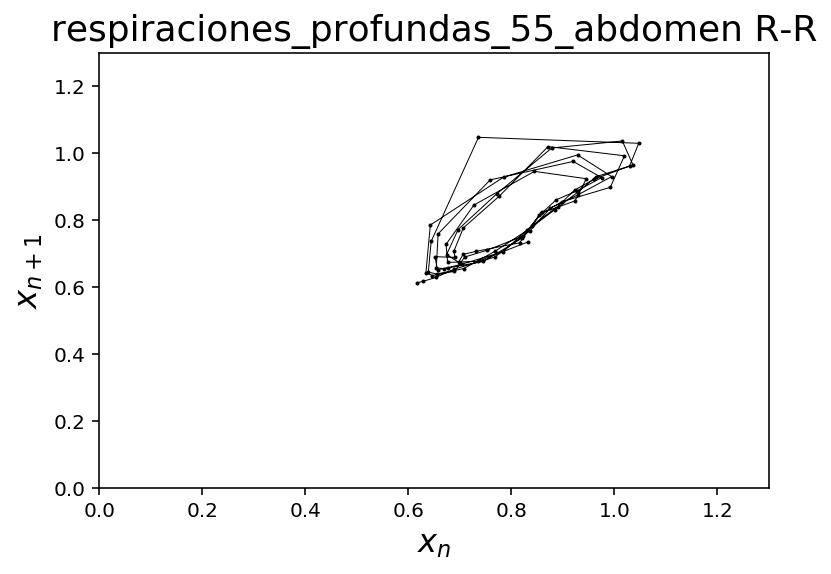

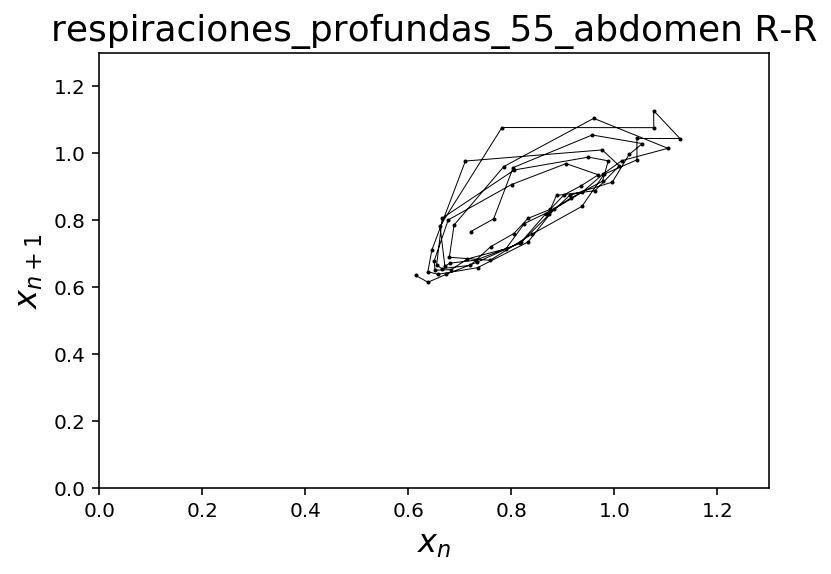

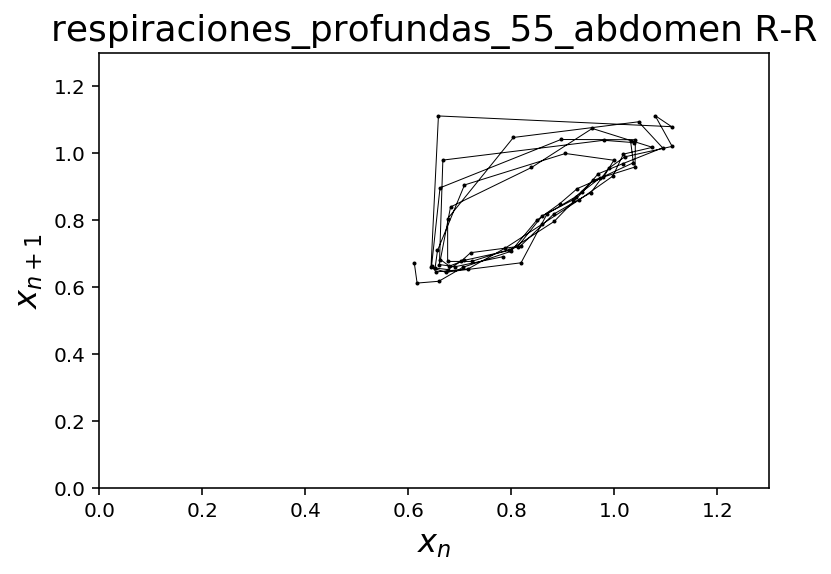

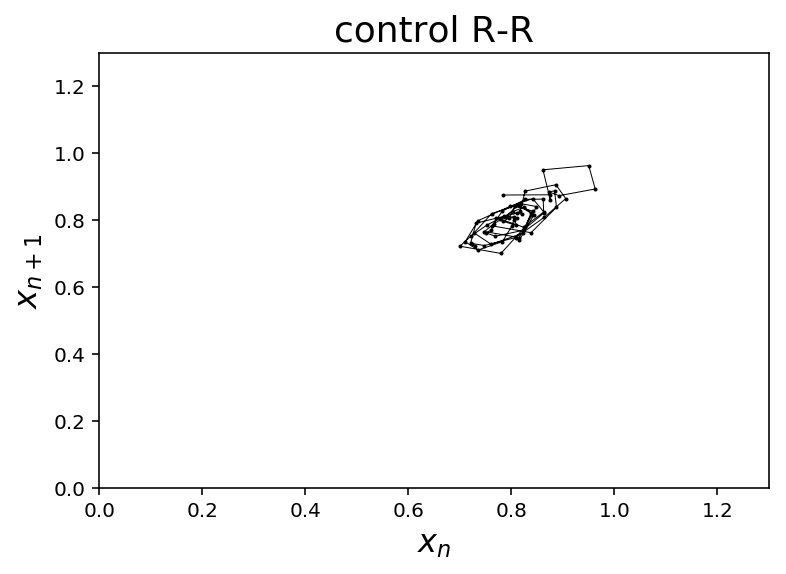

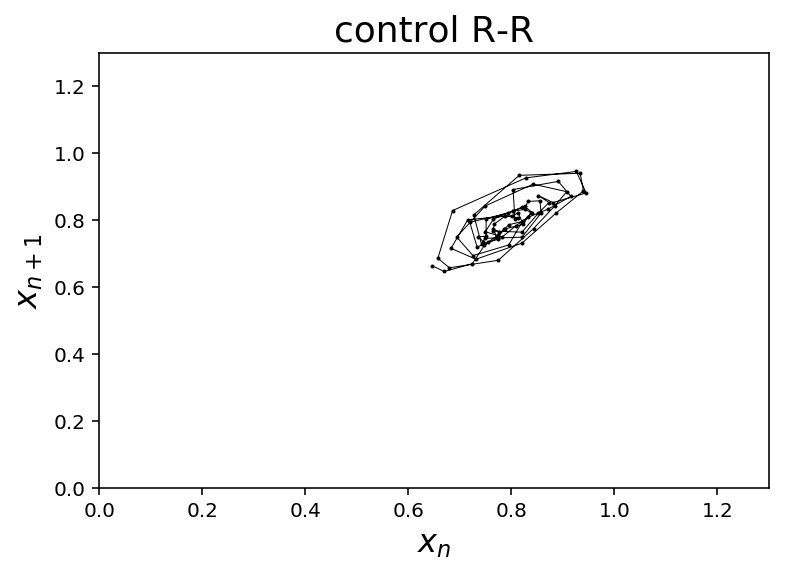

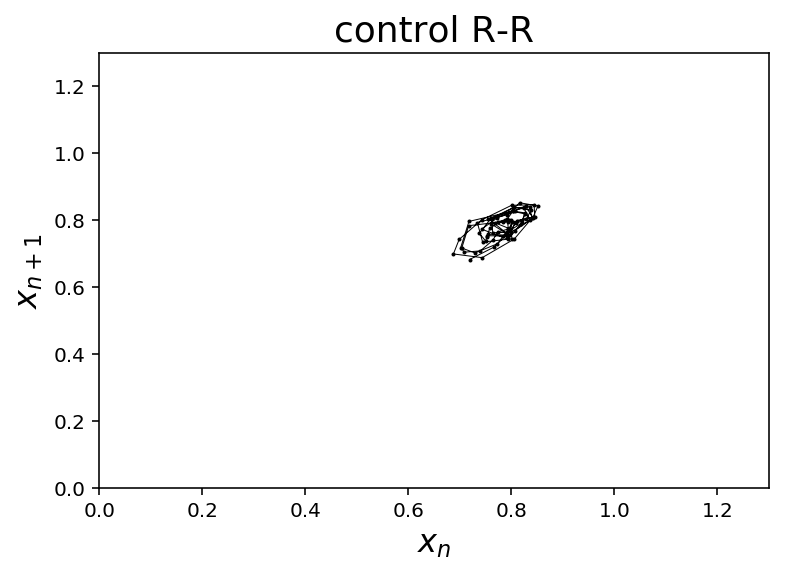

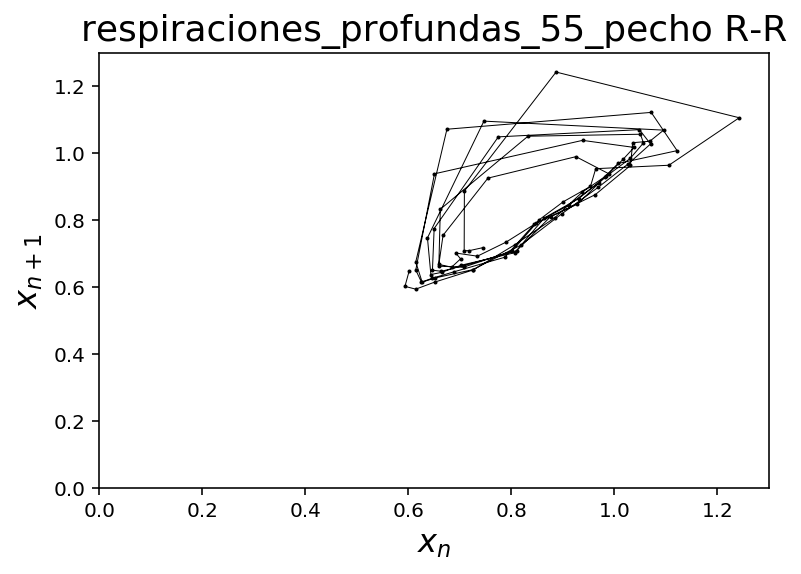

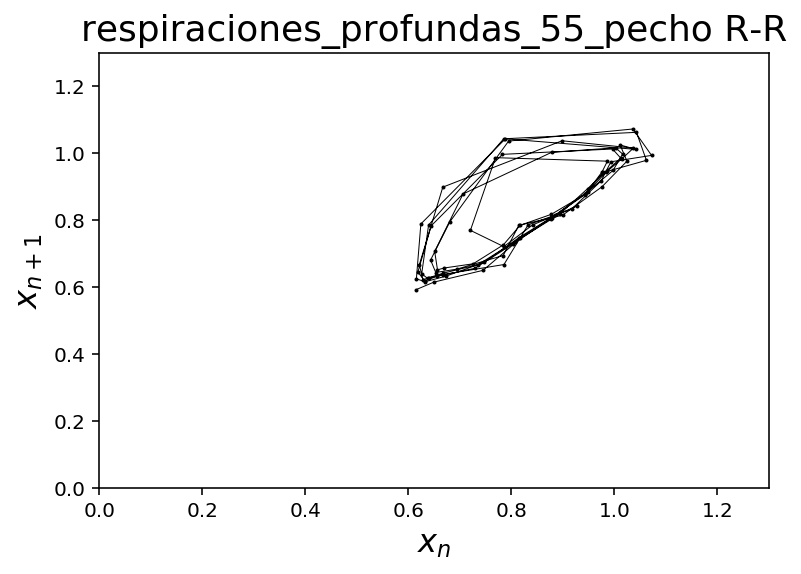

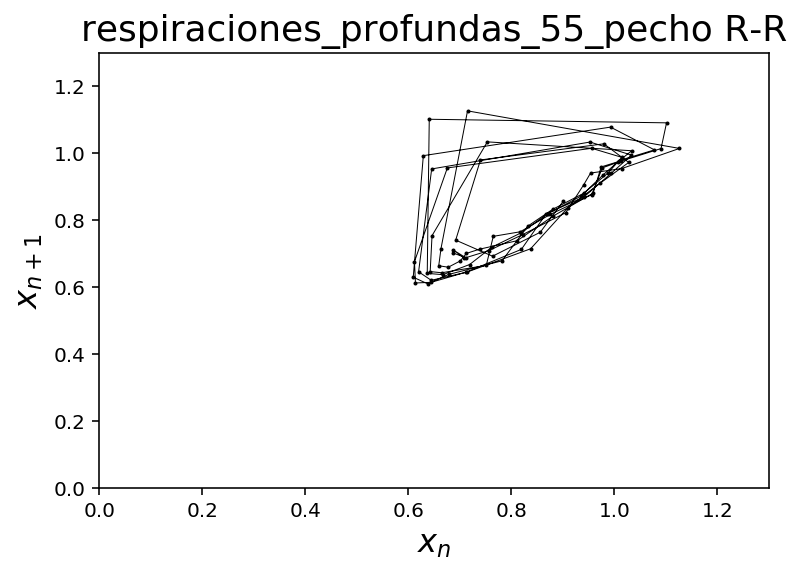

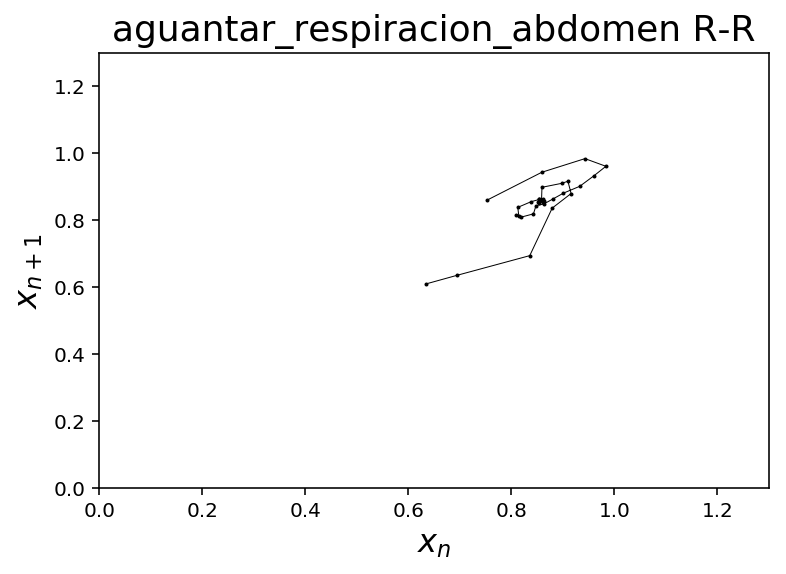

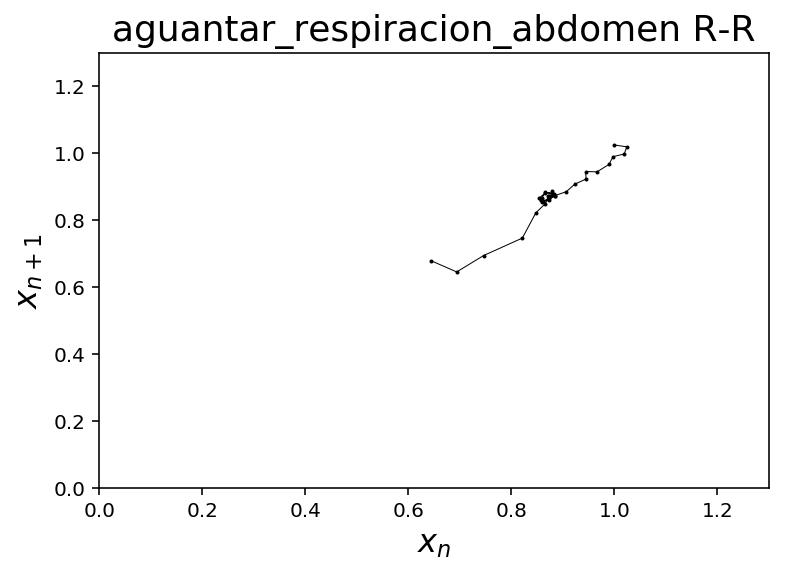

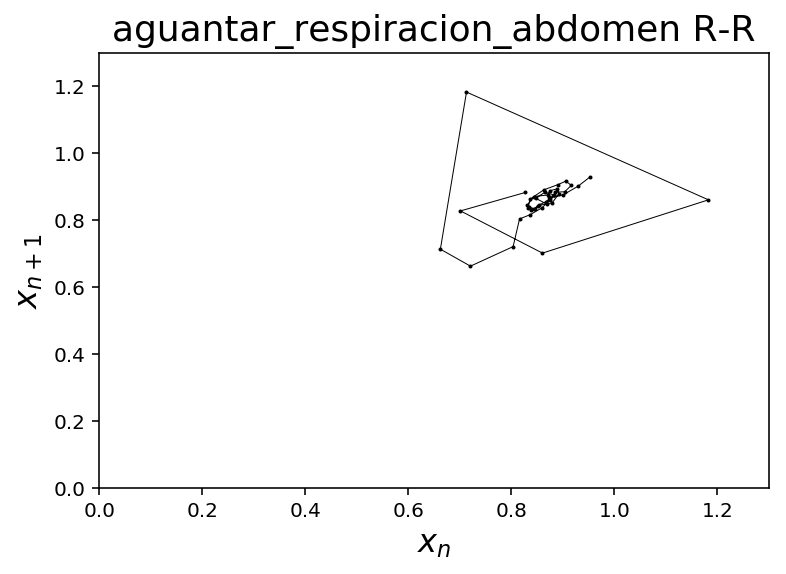

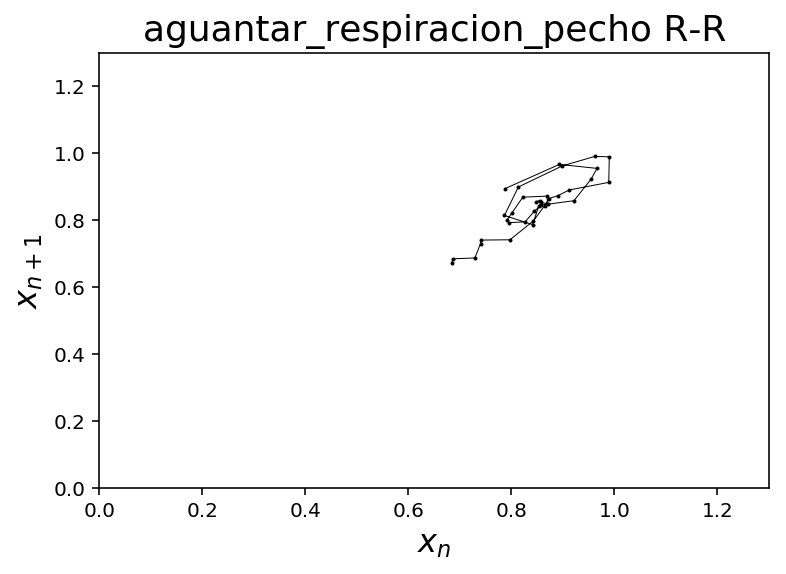

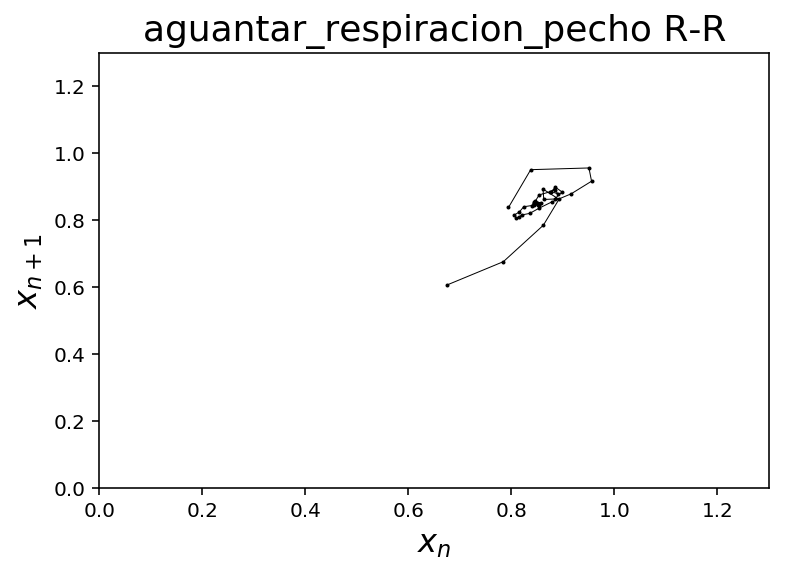

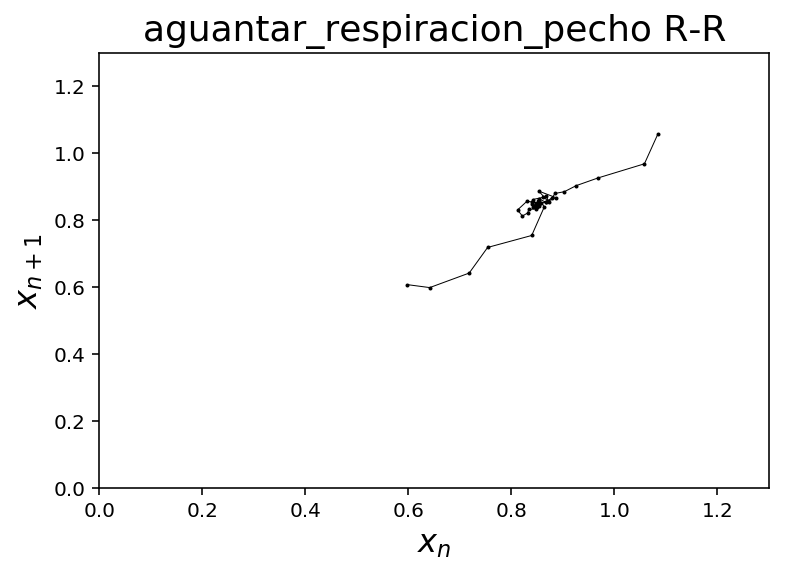

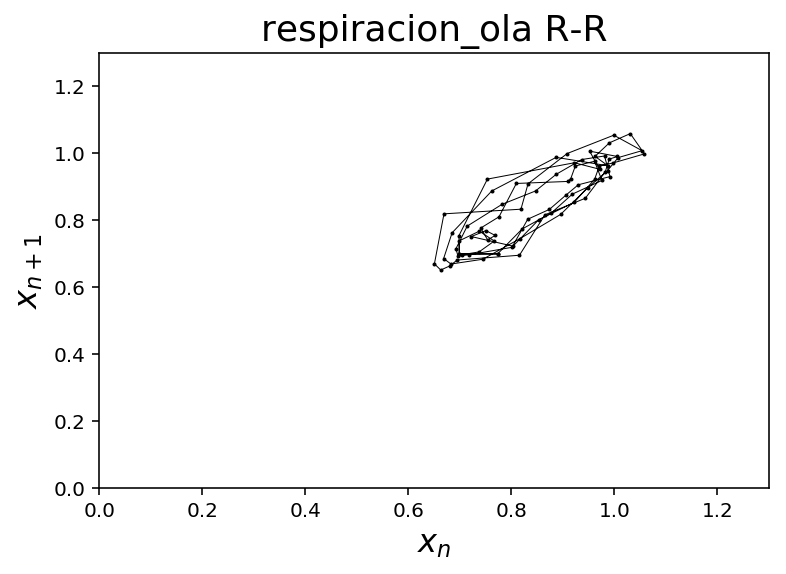

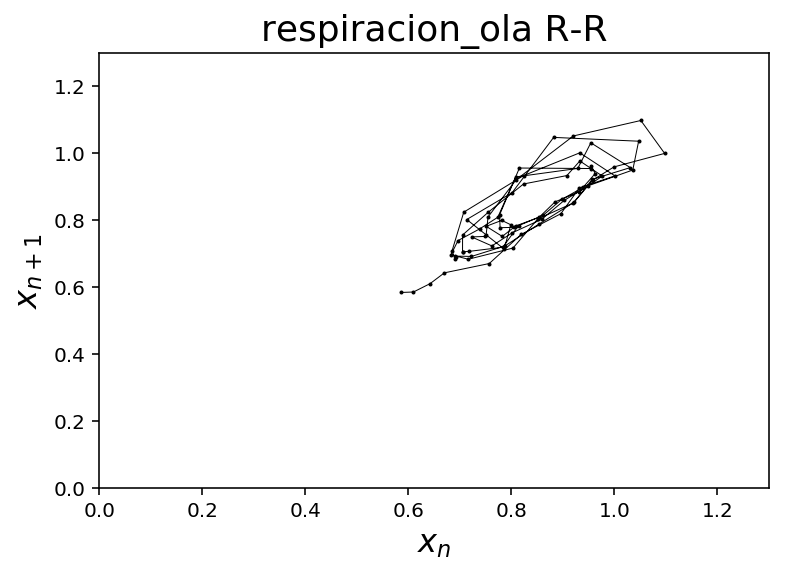

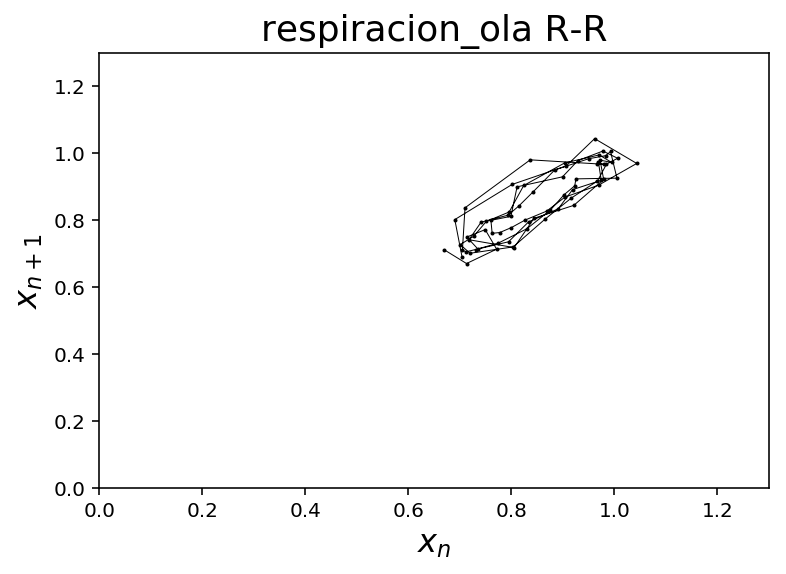

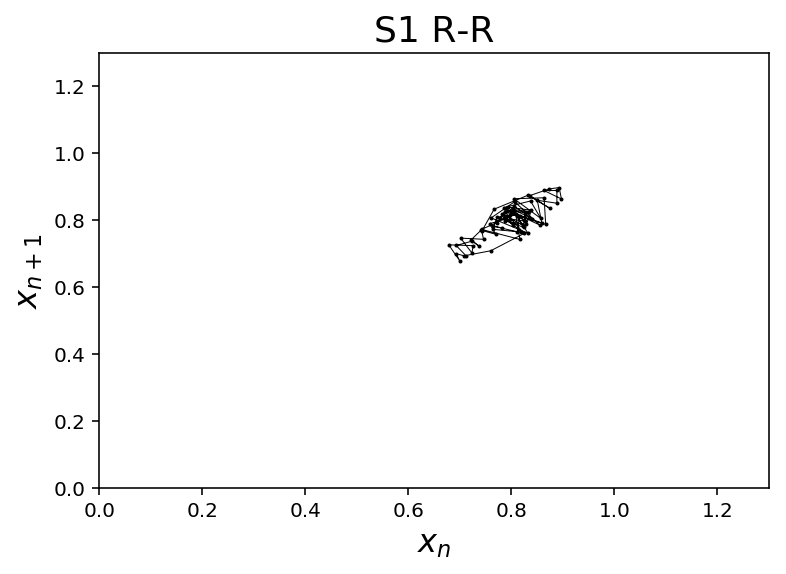

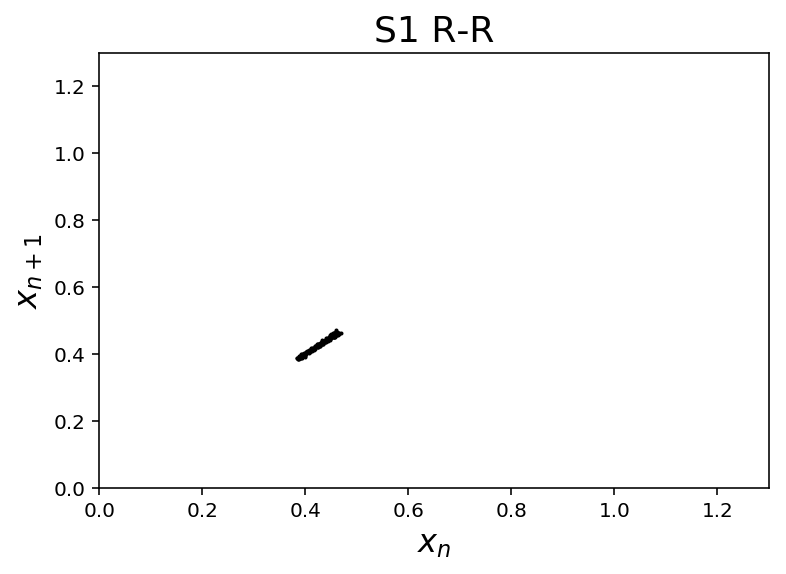

In [10]:
for i in range(len(recordings)):
    graph_phase_space(recordings[i].RR, 1, corresponding_folder[i])

Notice how the trajectory in phase space becomes smaller when the subject is holdings his breath.

With this time series, we will use Takens theorem to see what we can recontruct. The time delay we will use is 1 R-R interval.

Aqui podrías volver a superponer los registros de aguantar la respiración y los otros. Con los mismos colores que usaste en Poincaré a ver si se observa algún patrón.

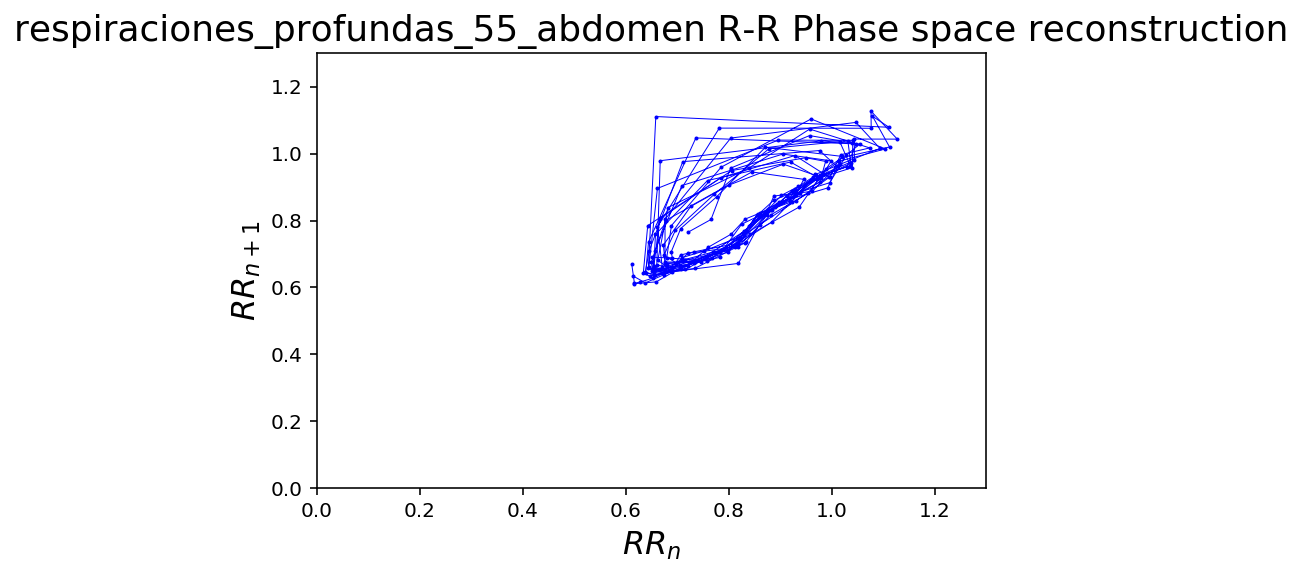

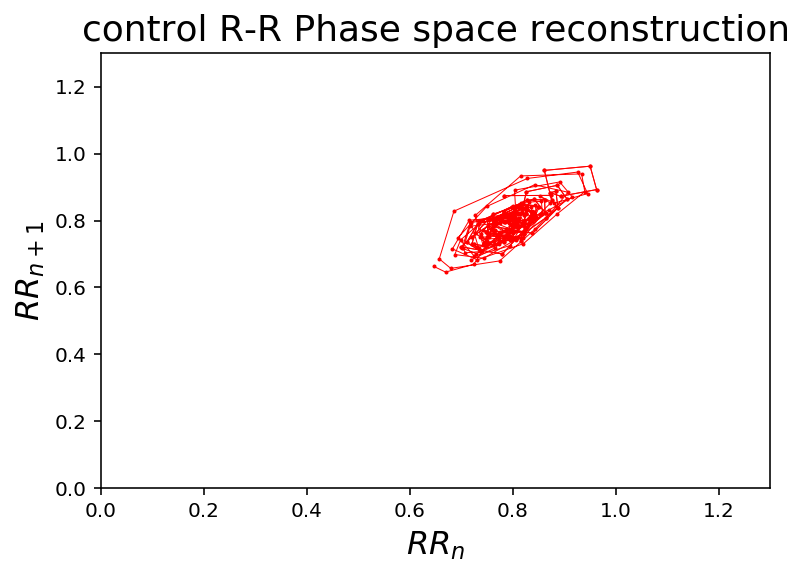

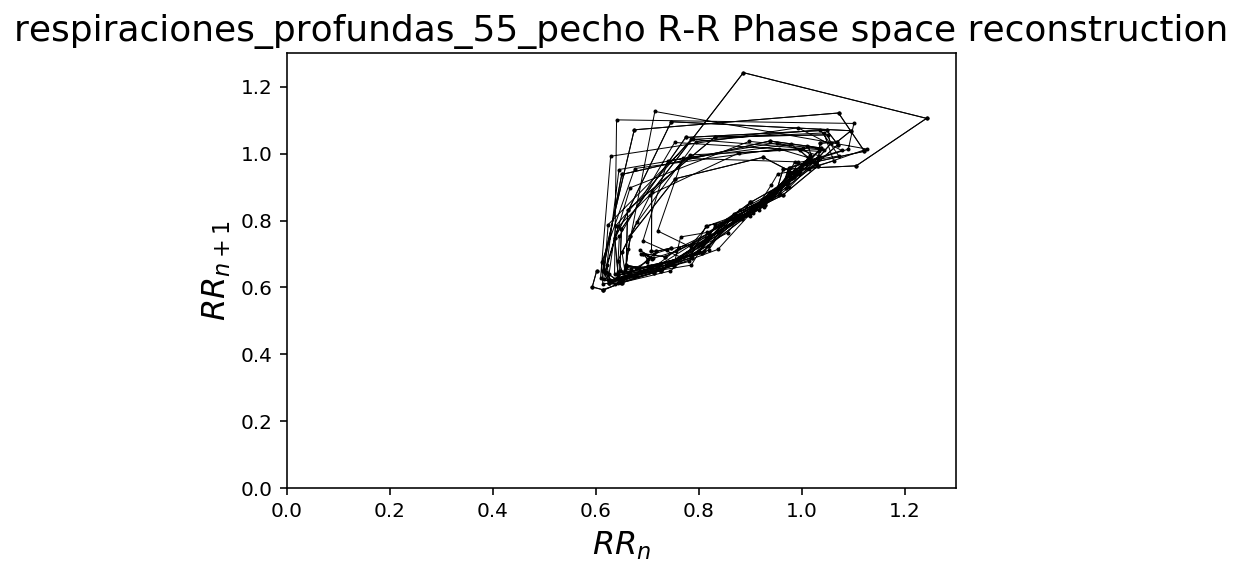

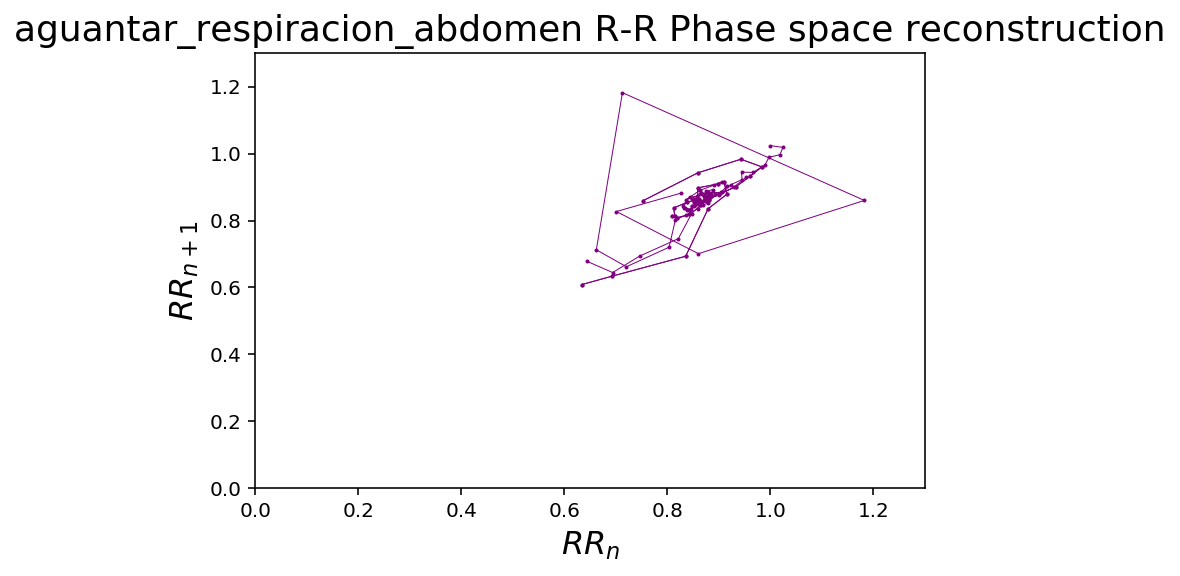

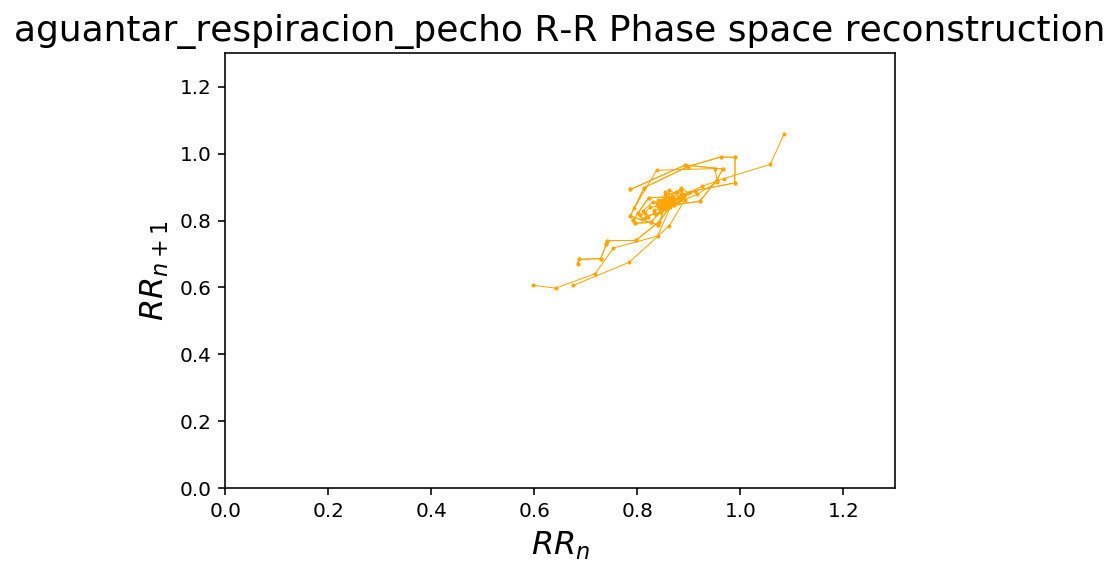

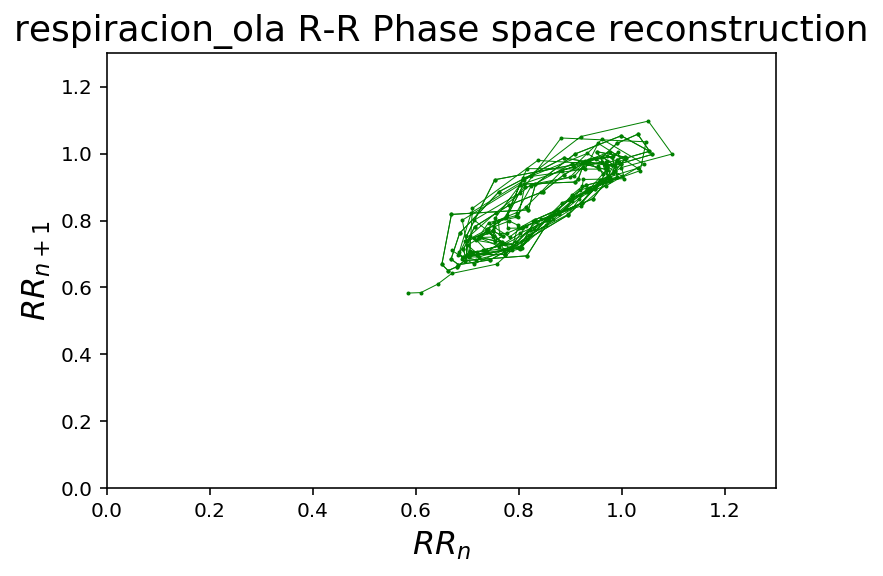

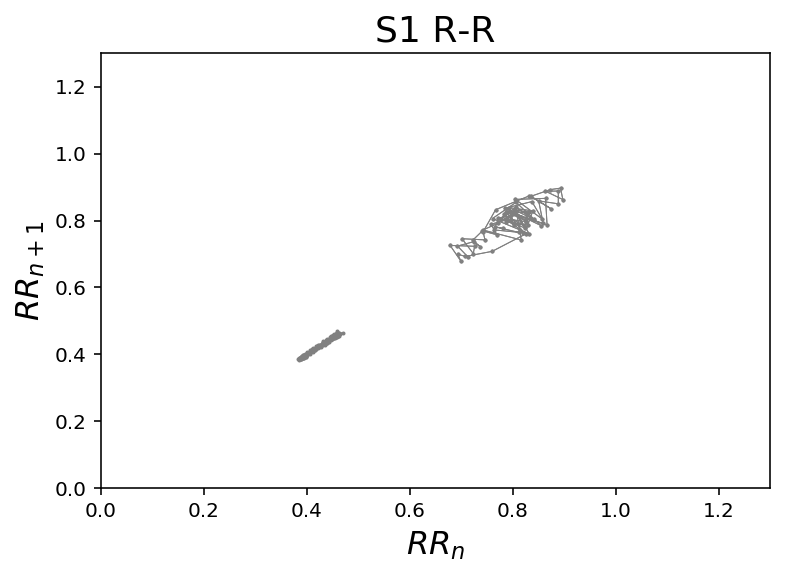

In [12]:
colors = ['blue', 'red', 'black', 'purple', "orange", "green", "grey"]
color_index = 0
time_delay = 1

for i in range(len(recordings)):
    n = np.size(recordings[i].RR) #size of the voltage vector
    
    if i!= 0 and corresponding_folder[i] != corresponding_folder[i-1]:
        color_index = color_index+1
        plt.title(str(corresponding_folder[i-1]) + " R-R Phase space reconstruction")
        plt.xlim(0, 1.3)
        plt.ylim(0, 1.3)
        plt.xlabel(r"$RR_n$")
        plt.ylabel(r"$RR_{n+1}$")
        plt.savefig('RR_intervals/phase_space_'+str(corresponding_folder[i])+'.jpg')#Saves images in folder

        plt.show()
        
        plt. plot(recordings[i].RR[0: n-time_delay], recordings[i].RR[time_delay: n],
              marker = "o", markersize = 1, linewidth = 0.5, c= colors[color_index])
        
    plt. plot(recordings[i].RR[0: n-time_delay], recordings[i].RR[time_delay: n],
              marker = "o", markersize = 1, linewidth = 0.5, c= colors[color_index])
    
plt.title(str(corresponding_folder[i-1]) + " R-R")
plt.xlim(0, 1.3)
plt.ylim(0, 1.3)
plt.xlabel(r"$RR_n$")
plt.ylabel(r"$RR_{n+1}$")
plt.savefig('RR_intervals/phase_space_'+str(corresponding_folder[i])+'.jpg')#Saves images in folder
plt.show()

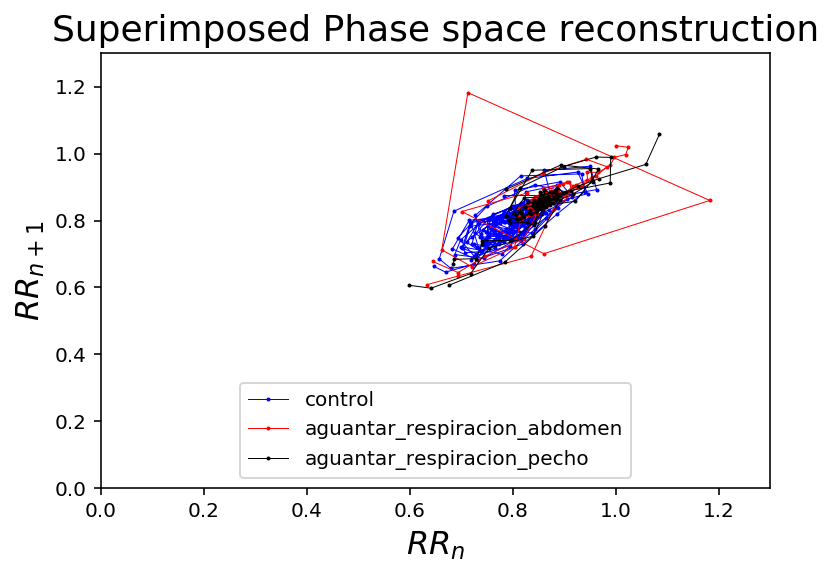

In [13]:
# Comparison between control, holding breath in chest and holding breath in abdomen
colors = ['blue', 'red', 'black', 'purple', "orange", "green"]
color_index = 0
banner = False
time_delay = 1

for i in range(len(recordings)):
    if corresponding_folder[i]=="control" or "aguantar" in corresponding_folder[i]: #First event
        n = np.size(recordings[i].RR) #size of the voltage vector
        
        if banner == False: #First event
            plt. plot(recordings[i].RR[0: n-time_delay], recordings[i].RR[time_delay: n],
                      marker = "o", markersize = 1, linewidth = 0.5, c= colors[color_index],
                      label = corresponding_folder[i])
        else: #Other events, does not plot label
            plt. plot(recordings[i].RR[0: n-time_delay], recordings[i].RR[time_delay: n],
                      marker = "o", markersize = 1, linewidth = 0.5, c= colors[color_index])
        banner = True
        
    if len(recordings)-1 != i:
        if banner == True and corresponding_folder[i] != corresponding_folder[i+1]:
            color_index = color_index+1
            banner = False

        
plt.title("Superimposed Phase space reconstruction")
plt.xlabel(r"$x_n$")
y = r'$x_{n+1}$'
plt.ylabel(y)
plt.xlim(0, 1.3)
plt.ylim(0, 1.3)
plt.xlabel(r"$RR_n$")
plt.ylabel(r"$RR_{n+1}$")
plt.legend(loc='lower center')
plt.savefig('RR_intervals/phase_space_superimposed_aguantar.jpg') #Saves images in folder
plt.show()

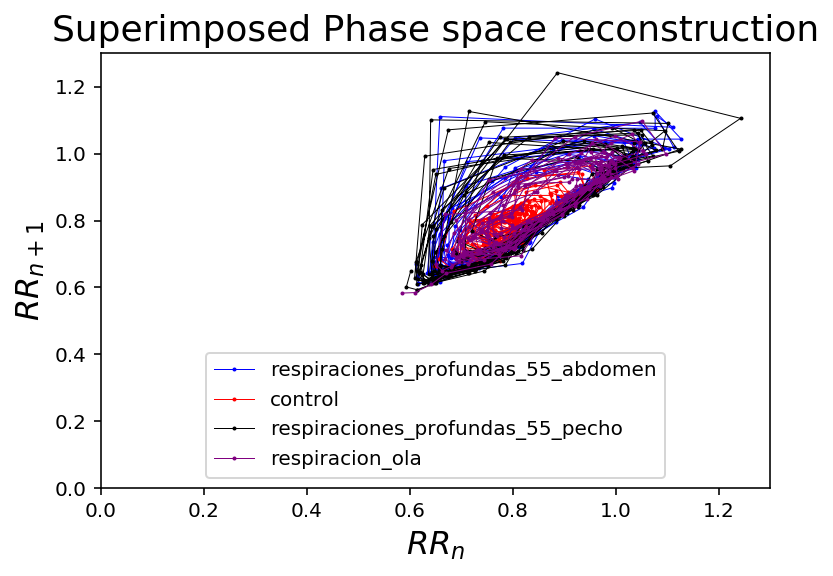

In [14]:
# Comparar: control, respiraciones profundas 55 pecho, respiraciones profundas 55 abdomen, respiraciones en ola.

colors = ['blue', 'red', 'black', 'purple', "orange", "green"]
color_index = 0
banner = False
time_delay = 1

for i in range(len(recordings)):
    if corresponding_folder[i]=="control" or "55" in corresponding_folder[i] or "ola" in corresponding_folder[i]: #First event
        n = np.size(recordings[i].RR) #size of the voltage vector
        
        if banner == False: #First event
            plt. plot(recordings[i].RR[0: n-time_delay], recordings[i].RR[time_delay: n],
                      marker = "o", markersize = 1, linewidth = 0.5, c= colors[color_index],
                      label = corresponding_folder[i])
        else: #Other events, does not plot label
            plt. plot(recordings[i].RR[0: n-time_delay], recordings[i].RR[time_delay: n],
                      marker = "o", markersize = 1, linewidth = 0.5, c= colors[color_index])
        banner = True
        
    if len(recordings)-1 != i:
        if banner == True and corresponding_folder[i] != corresponding_folder[i+1]:
            color_index = color_index+1
            banner = False

plt.title("Superimposed Phase space reconstruction")
plt.xlabel(r"$RR_n$")
y = r'$RR_{n+1}$'
plt.ylabel(y)
plt.xlim(0, 1.3)
plt.ylim(0, 1.3)
plt.legend(loc='lower center')
plt.savefig('RR_intervals/phase_space_superimposed_respirar.jpg') #Saves images in folder
plt.show()

### Exercise: Are the results obtained in a Poincaré plot and in a recurrence plot contradictory? While we are observing a loss in the first plot's variability with exercise, we are seeing the opposite in a recurrence plot. Why?

# Recurrence plots

This is a technique which compares every single data point to every other. Because of this reason, it is a very expensive algorithm computationaly. To reduce this computational time, we must create a surrogate data set. Be sure to create a surrogate data set that includes at least two QRS complexes.

In the following cell, change the start and end values to obtain two QRS complexes.

In [20]:
# Heat map Recurrence plot
def recurrence_plot(surrogate, data_point_delay = 25):
    n = len(surrogate)
    euclid = np.zeros((n,n), dtype = 'float')
    normal_euclid = np.zeros((n,n), dtype = 'float')

    #Cycle for obtaining the euclid distance between any two points
    for i in range(0, n-data_point_delay):
        for j in range(data_point_delay, n):
            euclid[i][j] = np.sqrt(np.abs(surrogate[i]**2 - surrogate[j]**2)) #euclidian norm

    normal_aux = np.max(euclid)

    # Cycle for normalizing the distance
    for i in range(0, n-data_point_delay):
        for j in range(data_point_delay, n):
            normal_euclid[i][j] = np.abs(euclid[i][j]/normal_aux-1)
            #Normalizing the values, and the farthest points have the lowest value (0),
            #while the nearest points have a value near 1

    return normal_euclid

def graph_recurrence(surrogate_data, index_surrogate, normal_euclid, label):
    
    #Initializing the graphic space
    fig = plt.figure(figsize=(6,8))
    gs = mpl.gridspec.GridSpec(2, 2, height_ratios=[1, 1], width_ratios=[2, 1])
    ax1 = fig.add_subplot(gs[1, 0])
    ax2 = fig.add_subplot(gs[0, 0], sharex=ax1)
    plt.tick_params(which='both', top=False, right=False)
    ax2.set_autoscalex_on(False)

    # Tachogram
    ax1.set_title("Tachogram")
    ax1.set_ylabel('R-R interval')
    ax1.set_xlabel('Time index')
    ax1.set_xlim(0, len(surrogate_data))
    ax1.plot(index_surrogate, surrogate_data, marker="o", c="k") #index_surrogate or time_surrogate (ms)

    # Recurrence plot
    ax2.set_title("Recurrence plot")
    plot = ax2.imshow(normal_euclid, origin='lower', aspect="auto", cmap="jet")
    axins = inset_axes(ax2,
                   width="5%", # width = 10% of parent_bbox width
                   height="100%", # height : 50%
                   loc=6,
                   bbox_to_anchor=(1.05, 0., 1, 1),
                   bbox_transform=ax2.transAxes,
                   borderpad=0,)

    cbar = plt.colorbar(plot, cax=axins)
    
    fig.savefig('recurrence_images/'+str(label)+'.jpg')#, bbox_inches='tight', dpi=150) #Saves images in folder
    
    plt.show()
    return None

An important detail to mention is that every recurrence plot is being normalized by its own metric. The biggest distance is being taken to normalize each individual recurrence plot. That means that colors in different plots are not necessarily equivalent. For example, what is red in one plot could be a lighter shade of orange in another.

In [21]:
normal_euclid = []

for i in range(len(recordings)):
    normal_euclid.append(recurrence_plot(recordings[i].RR, 1))
    print("Finished recording "+str(i+1))

Finished recording 1
Finished recording 2
Finished recording 3
Finished recording 4
Finished recording 5
Finished recording 6
Finished recording 7
Finished recording 8
Finished recording 9
Finished recording 10
Finished recording 11
Finished recording 12
Finished recording 13
Finished recording 14
Finished recording 15
Finished recording 16
Finished recording 17
Finished recording 18
Finished recording 19
Finished recording 20


Recording respiraciones_profundas_55_abdomen


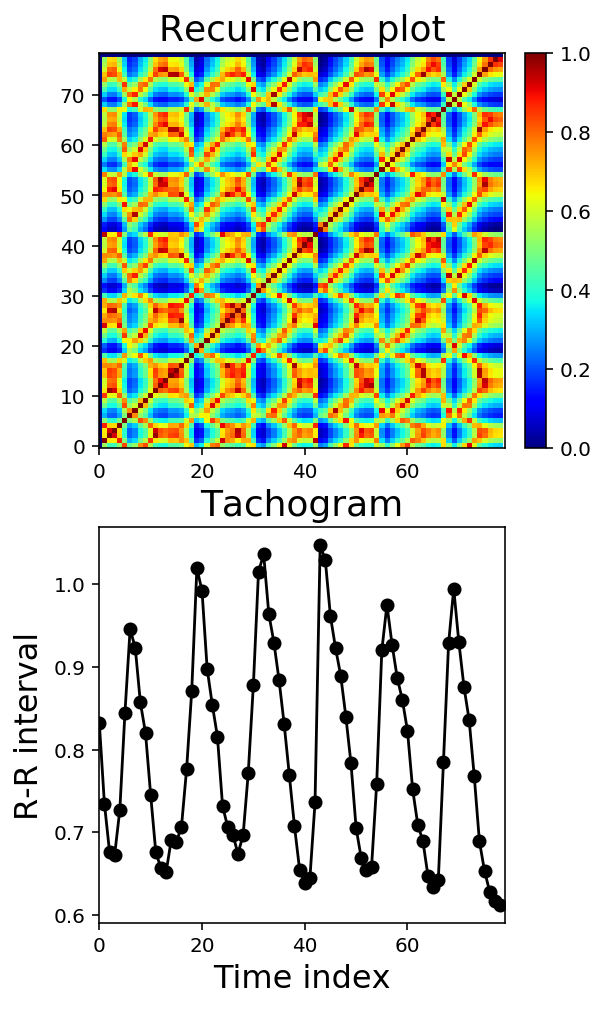

Recording respiraciones_profundas_55_abdomen


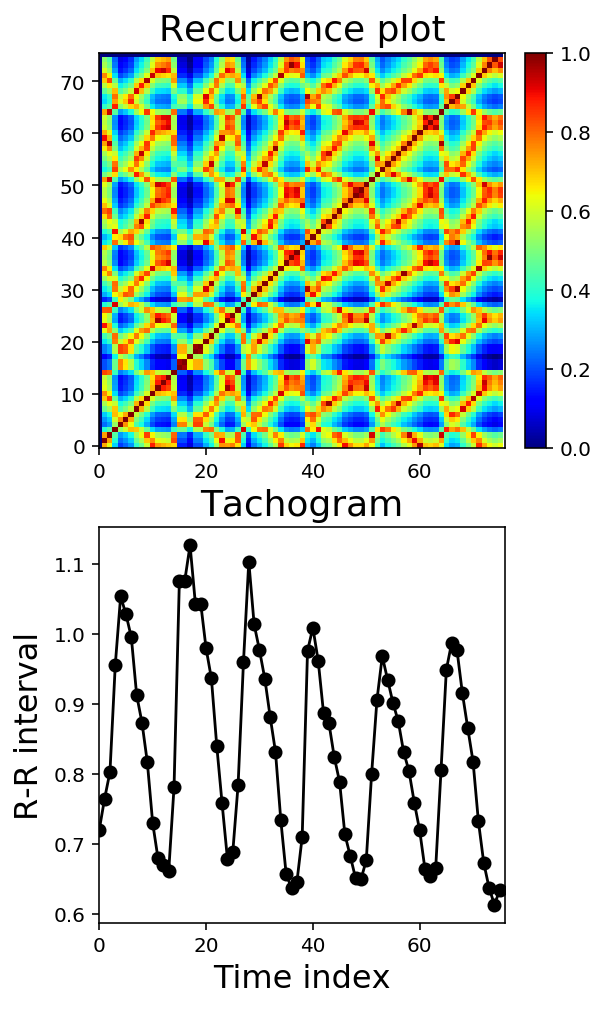

Recording respiraciones_profundas_55_abdomen


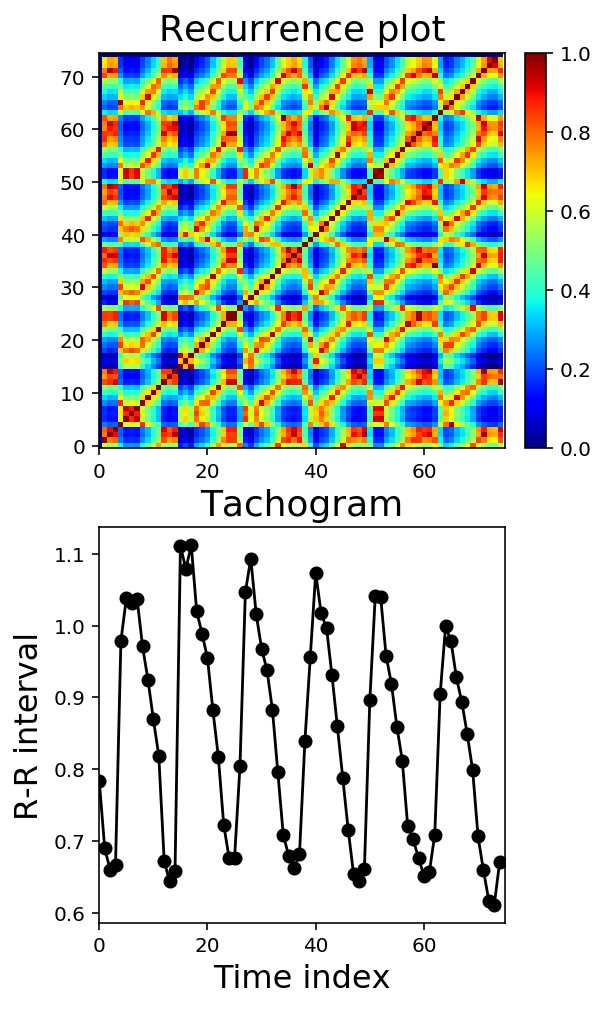

Recording control


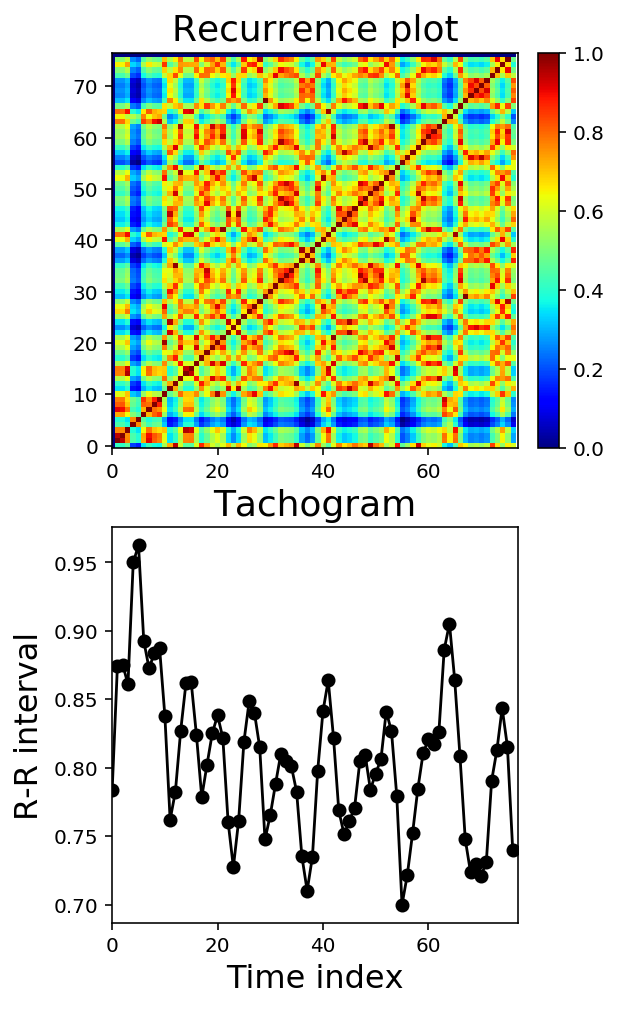

Recording control


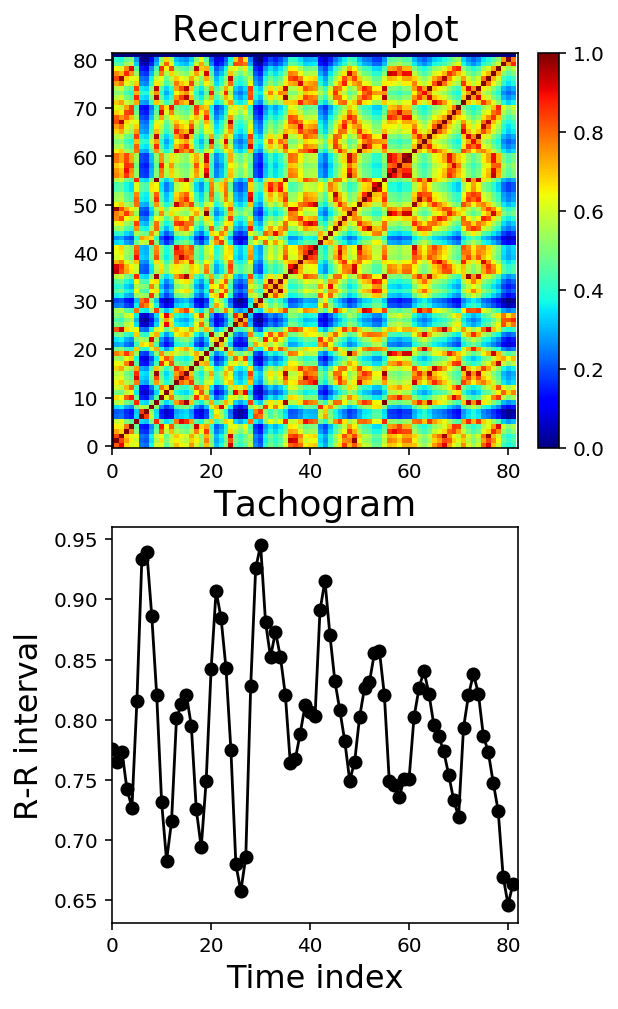

Recording control


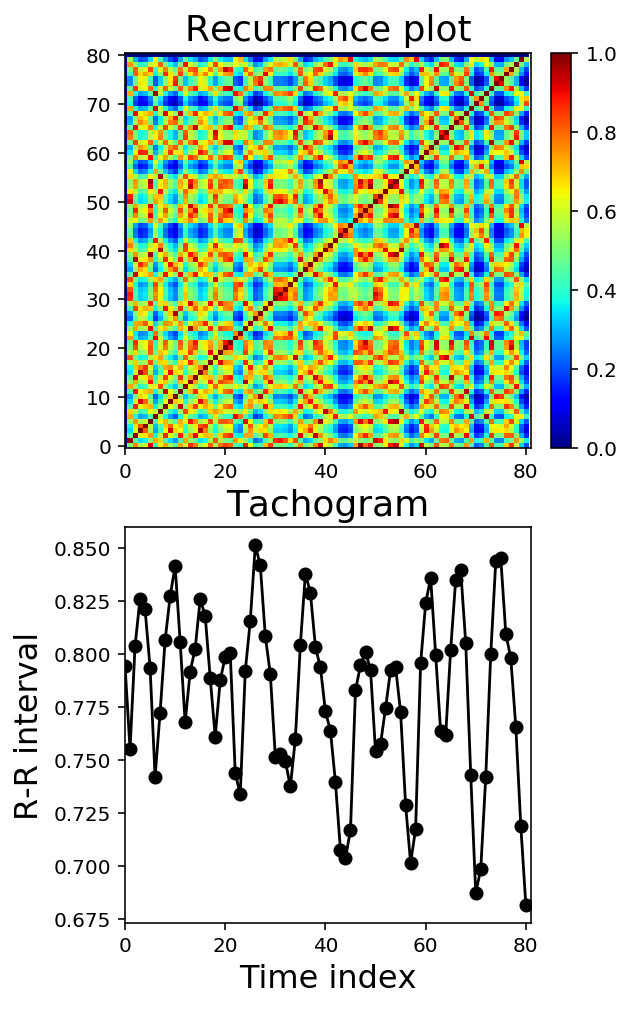

Recording respiraciones_profundas_55_pecho


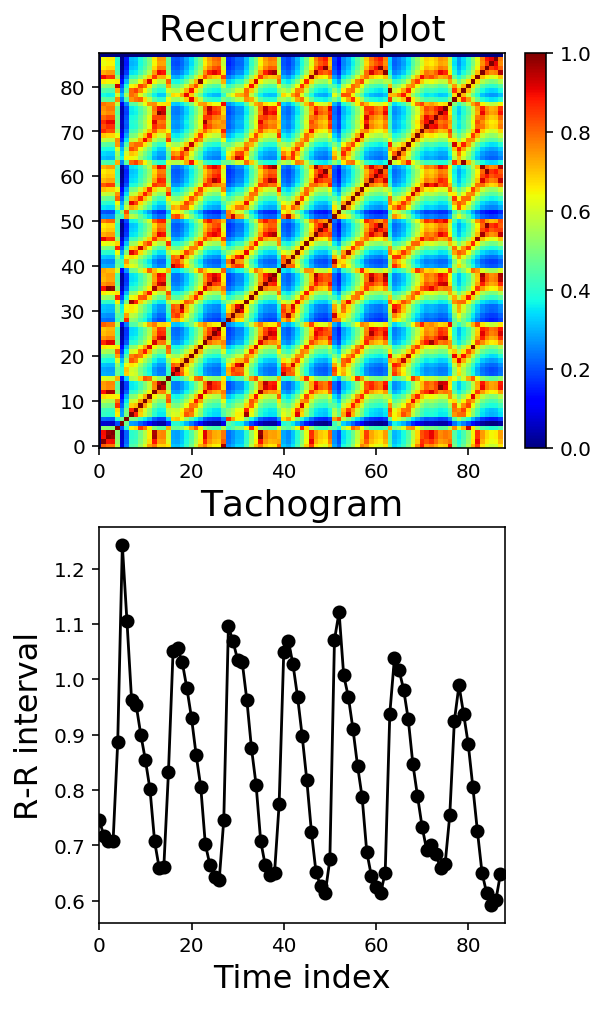

Recording respiraciones_profundas_55_pecho


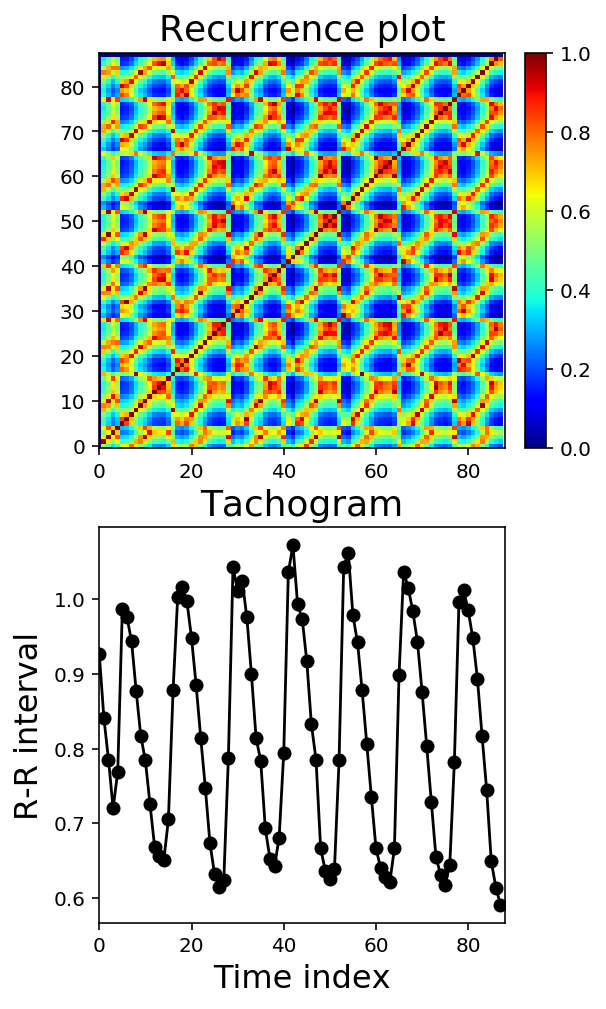

Recording respiraciones_profundas_55_pecho


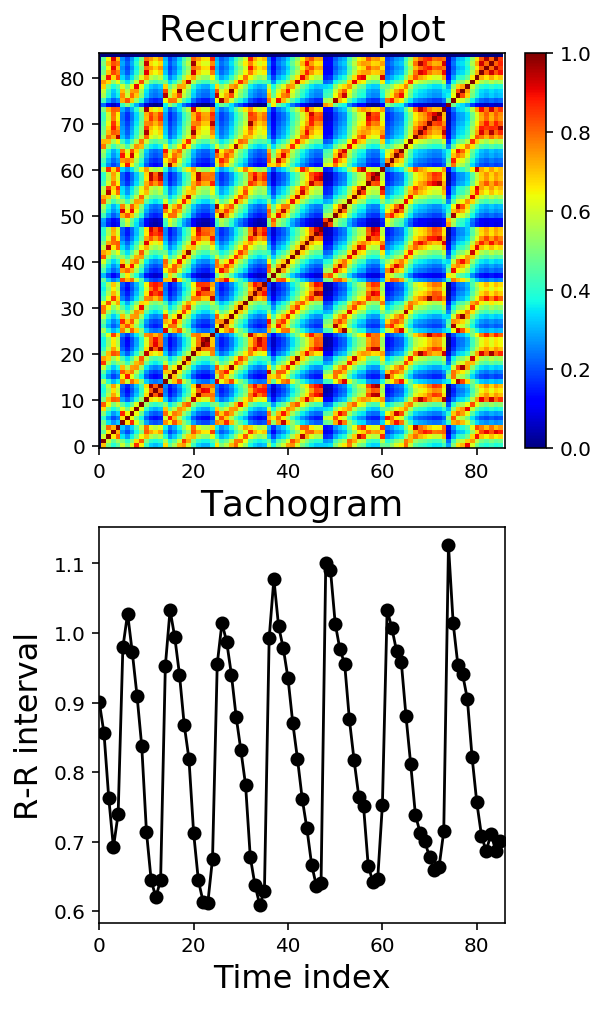

Recording aguantar_respiracion_abdomen


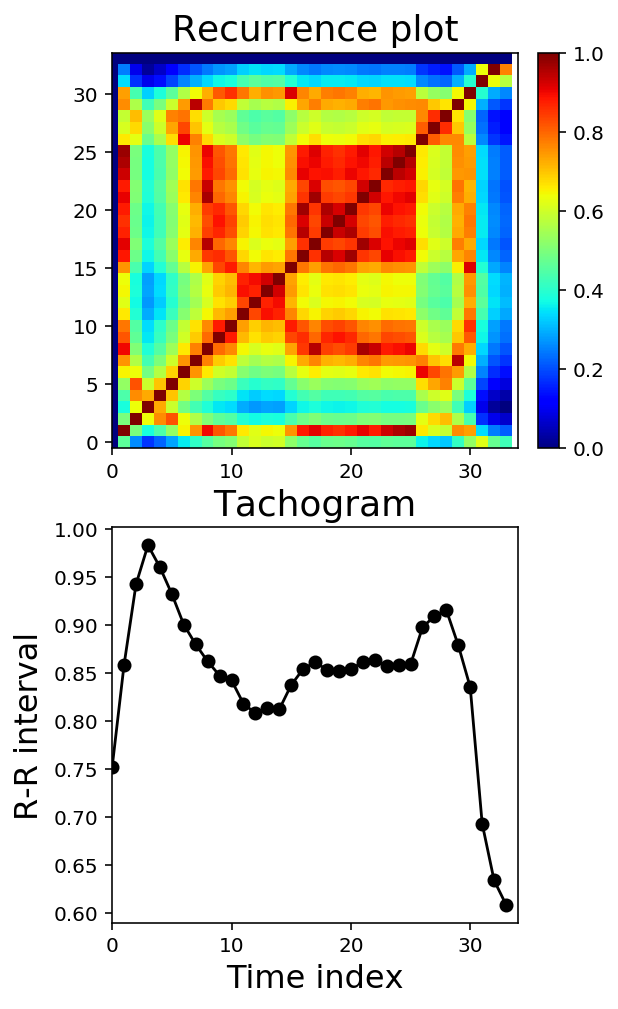

Recording aguantar_respiracion_abdomen


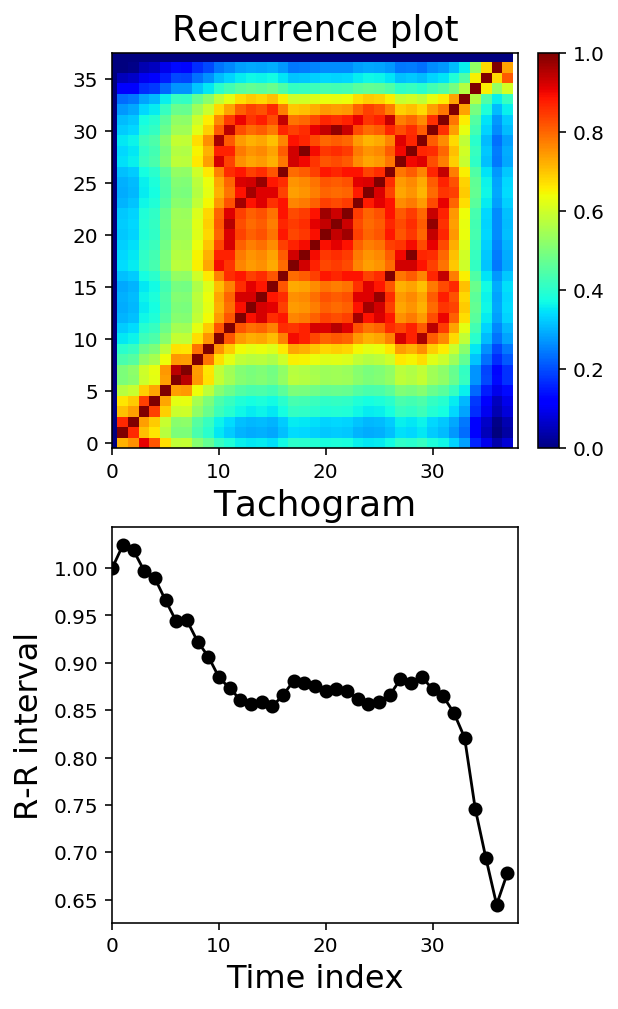

Recording aguantar_respiracion_abdomen


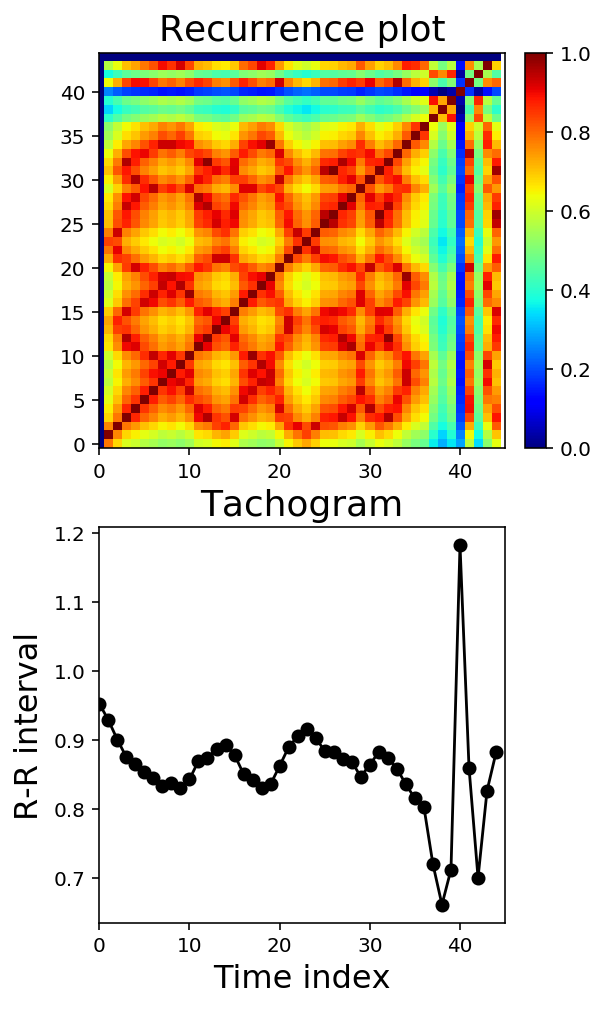

Recording aguantar_respiracion_pecho


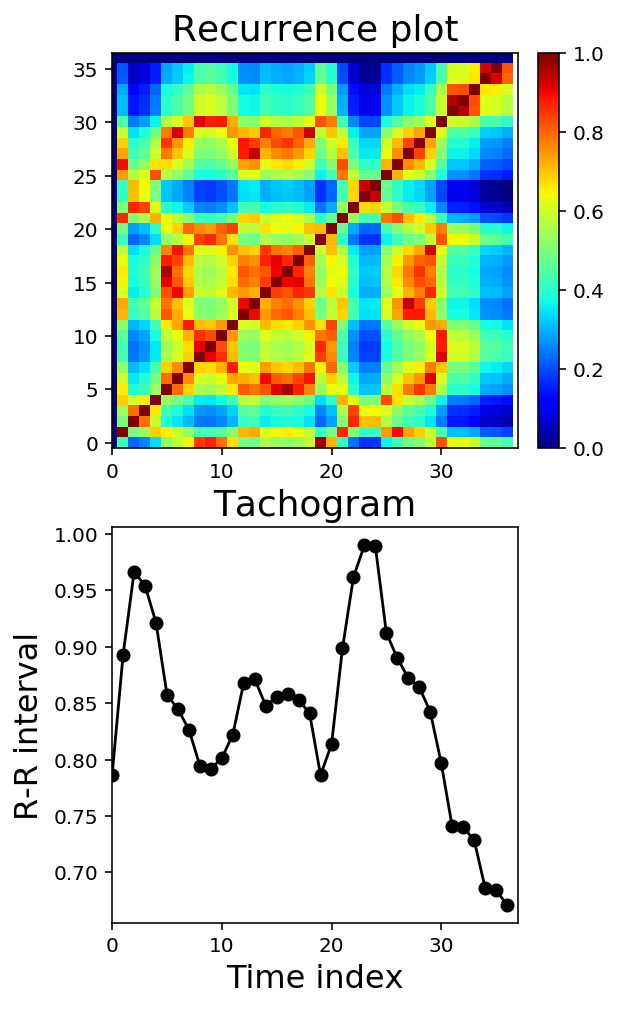

Recording aguantar_respiracion_pecho


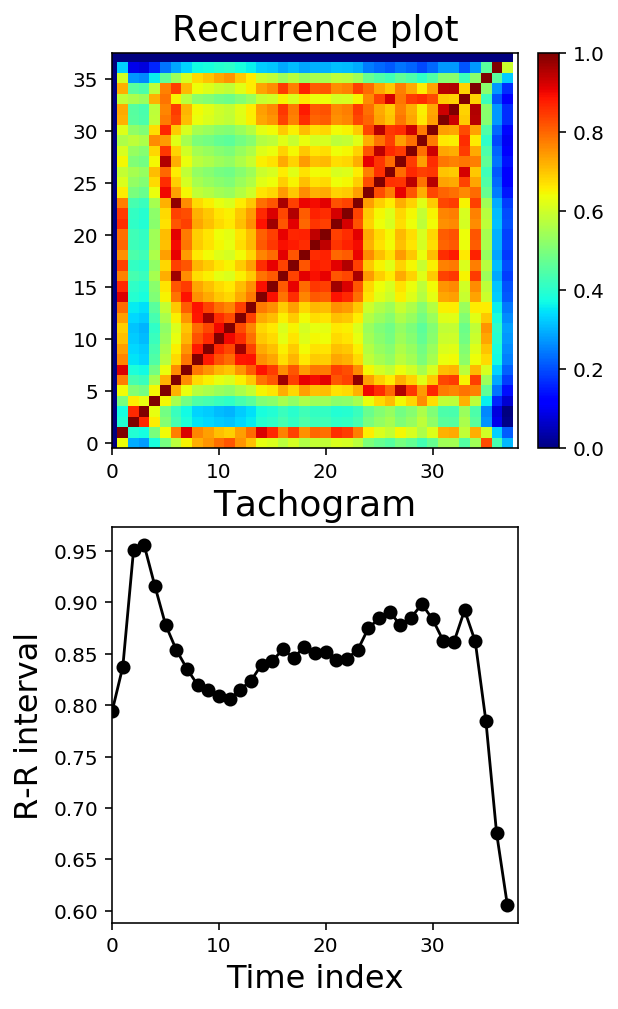

Recording aguantar_respiracion_pecho


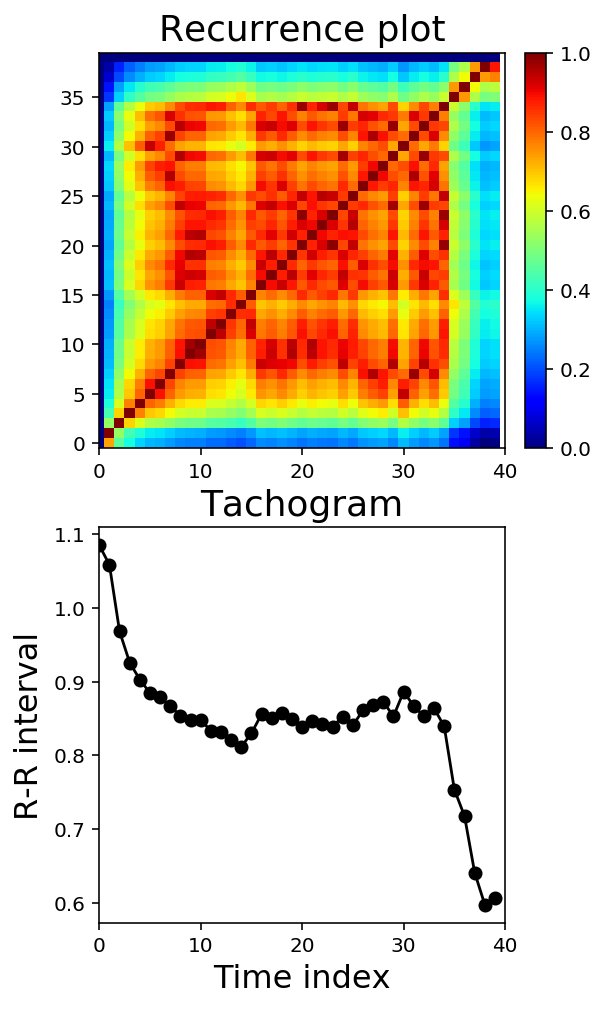

Recording respiracion_ola


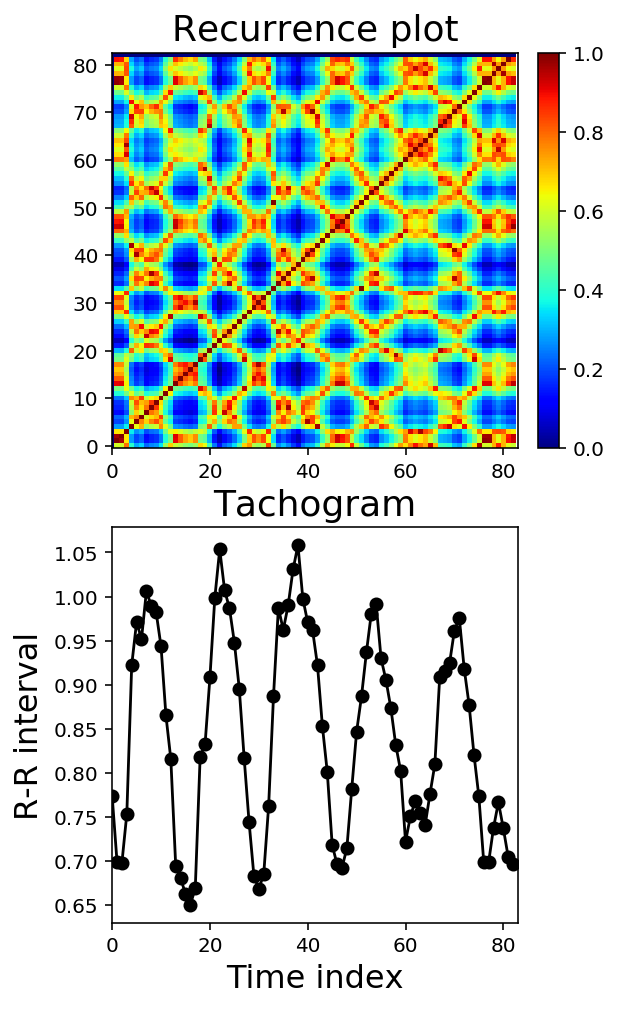

Recording respiracion_ola


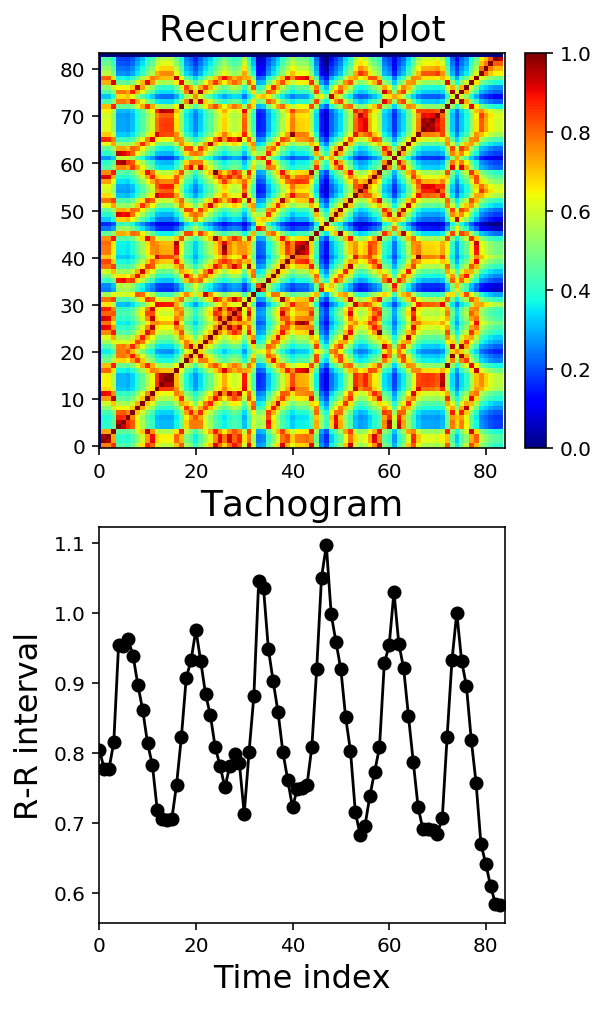

Recording respiracion_ola


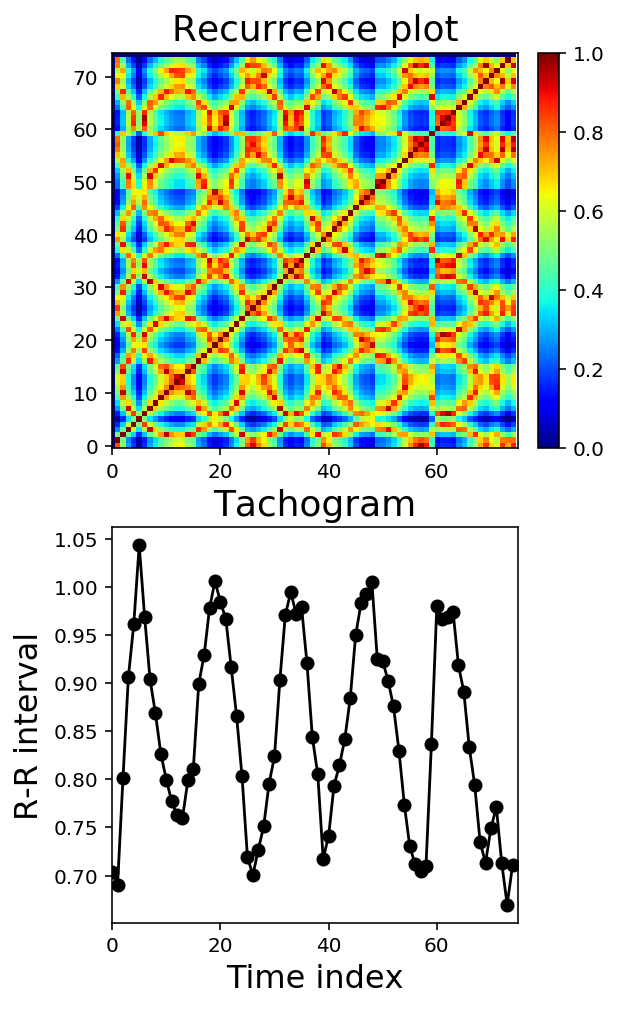

Recording S1


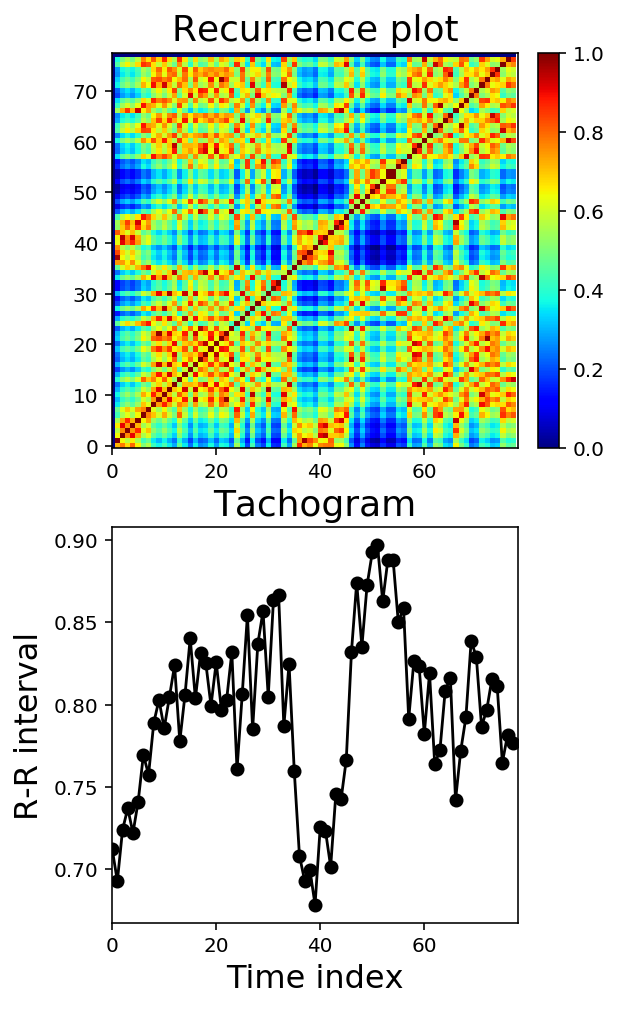

Recording S1


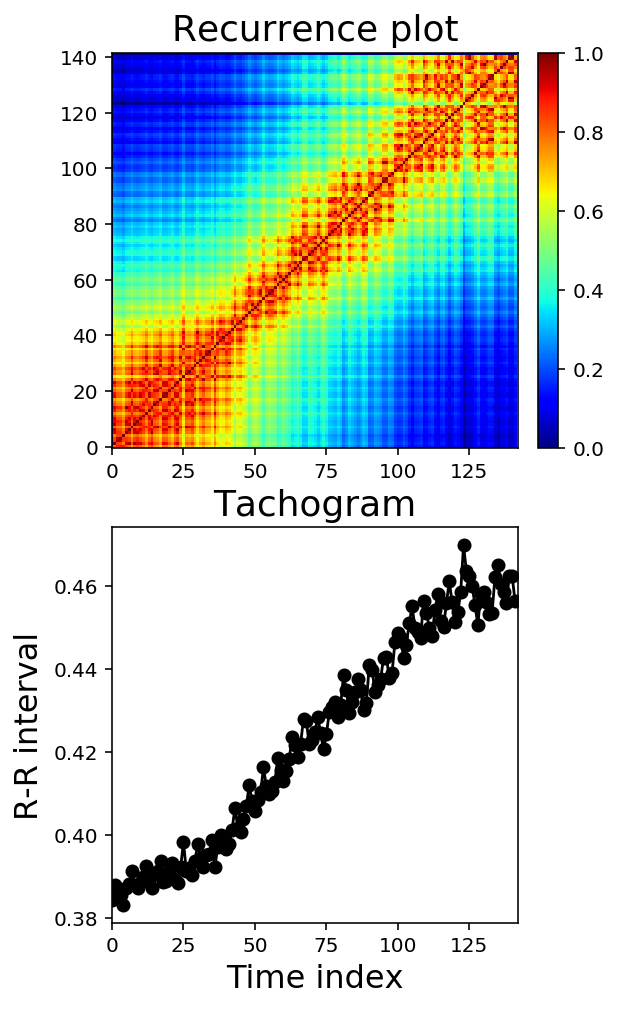

In [22]:
for i in range(len(recordings)):
    print("Recording " + corresponding_folder[i])
    graph_recurrence(recordings[i].RR,
                     [i for i in range(0, len(recordings[i].RR))], #Array of indexes
                     normal_euclid[i],
                     "rec"+str(i)+"_"+str(corresponding_folder[i]))

# Final remarks
As you have seen in this notebook, the R-R interval time series does provide valuable information for the analysis, even though there is lost information.